## Import Necessary Libraries

In [1]:
import os
from pathlib import Path
from langgraph.graph import StateGraph, END,START
from typing import TypedDict
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langgraph.graph import END, StateGraph
import mlflow

## Setup

In [2]:
class Config:
    DEBUG = os.getenv("DEBUG", "1") == "1"

    LOG_DIR = os.getenv("LOG_DIR", "logs")
    LOG_NAME = os.getenv("LOG_NAME", "LangGraph-Workflow")

    GRAPH_DIR = Path(os.getenv("GRAPH_DIR", "Graphs"))
    SAVE_GRAPH_PNG = os.getenv("SAVE_GRAPH_PNG", "1") == "1"

    MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
    MLFLOW_EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "LangGraph-Workflow")

    OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "granite4:350m")
    TEMPERATURE = float(os.getenv("TEMPERATURE", "0.0"))

    DDG_RESULTS = int(os.getenv("DDG_RESULTS", "5"))

    RECURSION_LIMIT = int(os.getenv("RECURSION_LIMIT", "30"))

In [3]:
llm = ChatOllama(model=Config.OLLAMA_MODEL, temperature=Config.TEMPERATURE)

In [4]:
mlflow.set_tracking_uri(Config.MLFLOW_TRACKING_URI)
mlflow.set_experiment(Config.MLFLOW_EXPERIMENT)
mlflow.langchain.autolog()

In [5]:
def print_workflow_info(workflow, app=None, *, title="WORKFLOW INFORMATION"):
    """
    Pretty-prints a LangGraph workflow using Rich (with a pprint fallback).

    - Shows nodes, edges, and finish points (best-effort attribute probing).
    - Optionally displays a notebook visualization if `app` is provided.
    """
    # --- Extract workflow info (best effort / defensive) ---
    nodes = getattr(workflow, "nodes", None)
    edges = getattr(workflow, "edges", None)

    # finish points: try public attr first, then common private fallback(s)
    finish_points = None
    for attr in ("finish_points", "_finish_points", "_finish_point", "finish_point"):
        if hasattr(workflow, attr):
            finish_points = getattr(workflow, attr)
            break

    info = {
        "nodes": nodes,
        "edges": edges,
        "finish_points": finish_points,
        "node_count": len(nodes) if hasattr(nodes, "__len__") else None,
        "edge_count": len(edges) if hasattr(edges, "__len__") else None,
    }

    # --- Pretty output ---
    try:
        from rich.console import Console
        from rich.panel import Panel
        from rich.table import Table
        from rich.pretty import Pretty

        console = Console()

        table = Table(show_header=False, box=None)
        table.add_row("Nodes", str(info["node_count"]))
        table.add_row("Edges", str(info["edge_count"]))
        table.add_row("Finish points", "Yes" if info["finish_points"] is not None else "Unknown")

        console.print(Panel(table, title=title))
        console.print(Panel(Pretty(info, expand_all=True), title="Details"))

    except Exception:
        # Fallback: standard library pprint
        import pprint
        print(title)
        print("=" * len(title))
        pprint.pprint(info, width=100, sort_dicts=False)

    # --- Optional notebook visualization ---
    if app:
        try:
            from IPython.display import display, Image
            display(Image(app.get_graph().draw_mermaid_png()))
        except Exception as e:
            print(f"(Visualization unavailable: {e})")


## Prompt Chaining

Prompt Chaining is a workflow design pattern where complex tasks are decomposed into a sequence of LLM (Large Language Model) calls. Each step depends on the output of the previous one, allowing for step-by-step refinement or evolution of the data being processed. This method mirrors how humans tackle multifaceted problems—by breaking them down into manageable steps.

It leverages **function calling**, **sequential chaining** and or **AI Agents** , often implemented using frameworks such as **LangChain**, **LangGraph**, or even custom scripts. The key is modularity and clarity—each node (or step) has a specific role in the overall pipeline. Each link in the chain is a tool call or Agent the structure of which is something like the following:

#### Typical Structure:
- **Step 1:** Initial LLM prompt (for example, generate a draft)
- **Step 2:** Refinement prompt (for example, improve style, tone)
- **Step 3:** Evaluation or formatting (for example, convert to specific format or assess quality)

This pattern also allows injecting **external tools** between steps (for example, validation, summarization, keyword extraction).

---

#### Use Cases:
- Generating blog posts or marketing copy step-by-step (idea → outline → paragraph → polish)
- Automated report generation (for example, extract → analyze → summarize)
- Educational content creation (for example, topic → questions → answers → explanations)

---


### Use Case: Prompt Chaining — Job Application Assistant

In this workflow, we are going to build a simple **job application assistant** using the Prompt Chaining pattern. The goal is to help a user create a **personalized cover letter** from a given job description.

We will break the task into two sequential steps:
1. First, the LLM will read the **job description** and generate a **resume summary** tailored to that role.
2. Then, using this summary, the LLM will generate a professional **cover letter** suitable for submitting with a job application.


For this workflow, we need a structured way to manage the data passed between each step. To achieve this, we define a `ChainState` using `TypedDict`. This state will act as a shared container for all intermediate and final outputs.

- First, we have `job_description`, which will store the input provided by the user, typically a job posting or role summary.
- Then, we include `resume_summary`, which will hold the tailored summary of the applicant’s profile generated by the LLM based on the job description.
- Finally, we have `cover_letter`, where the personalized cover letter will be stored after the second LLM call completes. 


In [6]:
class ChainState(TypedDict):
    job_description: str
    resume_summary: str
    cover_letter: str

Now, let's see how to build a prompt chain using a series of LLM calls—as in, agents. We'll demonstrate the process, which is summarized in the following image. The input is a state variable containing the job description. This is first passed to the Resume Summary agent, which generates a summary of the resume and stores it under the key resume_summary. That output is then used as input for the Generate Cover Letter agent, which produces a cover letter and fills in the key cover_letter.
![Screenshot 2025-04-24 at 12.03.31 PM.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hseuyL5ddwU6cvKXrVGQnw/Screenshot%202025-04-24%20at%2012-03-31%E2%80%AFPM.png)


## Resume Summary Agent

In LLM workflows, an "agent" is created through a prompt that gives the LLM specific instructions and persona. The generate_resume_summary node demonstrates this by transforming the LLM into a "resume assistant" through its prompt. This node receives the state containing the job description, processes it using the agent created by the prompt, and returns an updated state with the new resume summary.
Nodes provide the workflow structure while prompts define agent capabilities. The state object serves as shared memory between nodes, allowing each agent to build upon previous work while using the same underlying LLM instance.


In [7]:
def generate_resume_summary(state: ChainState) -> ChainState:
    prompt = f"""
You're a resume assistant. Read the following job description and summarize the key qualifications and experience the ideal candidate should have, phrased as if from the perspective of a strong applicant's resume summary.

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "resume_summary": response.content}

## Generate Cover Letter Agent


The ```generate_cover_letter``` node defines our second agent in the workflow. This function creates a specialized agent through its prompt This agent accesses both ```state['resume_summary']``` and ```state['job_description'] ```from the current state, leveraging both the output from the previous agent and the original input. The prompt transforms the LLM into a cover letter specialist that synthesizes these elements into a tailored application document. The agent's output is then added to the state dictionary under the ```cover_letter``` key, completing the workflow chain with a state object containing all three key elements.


In [8]:
def generate_cover_letter(state: ChainState) -> ChainState:
    prompt = f"""
You're a cover letter writing assistant. Using the resume summary below, write a professional and personalized cover letter for the following job.

Resume Summary:
{state['resume_summary']}

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "cover_letter": response.content}

## LangGraph Workflow 
### Initializing the LangGraph Workflow

This line creates a new `StateGraph` instance and configures it with our `ChainState` definition. This crucial step establishes the workflow's foundation by specifying the structure of data that will flow through the nodes. The `StateGraph` uses the `ChainState` TypedDict to validate data types for each field (`job_description`, `resume_summary`, and `cover_letter`), ensuring proper information passing between nodes. This data contract enables LangGraph to manage state transitions efficiently as the workflow progresses from node to node.


In [9]:
workflow = StateGraph(ChainState)

workflow.add_node("generate_resume_summary", generate_resume_summary)
workflow.add_node("generate_cover_letter", generate_cover_letter)

workflow.set_entry_point("generate_resume_summary")
workflow.add_edge("generate_resume_summary", "generate_cover_letter")
workflow.set_finish_point("generate_cover_letter")
workflow

In [10]:
app = workflow.compile()

╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          2                                                                                               │
│  Edges          3                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'generate_resume_summary': StateNodeSpec(                                                               │
│             runnable=generate_resume_summary(tags=None, recurse=True, explode_args=False, func_accepts={}),     │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.ChainState'>,                                                         │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'generate_cover_letter': StateNodeSpec(                                                                 │
│             runnable=generate_cover_letter(tags=None, recurse=True, explode_args=False, func_accepts={}),       │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.ChainState'>,                                                         │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         )                                                                                                       │
│     },                                                                                                          │
│     'edges': {                                                                                                  │
│         (                                                                                                       │
│             'generate_resume_summary',                                                                          │
│             'generate_cover_letter'                                                                             │
│         ),                                                                                                      │
│         (                                                                                                       │
│             'generate_cover_letter',                                                                            │
│             '__end__'                                                                                           │
│         ),                                                                                                      │
│         (                                                                                                       │
│             '__start__',                                                                                        │
│             'generate_resume_summary'                                                                           │
│         )                                             

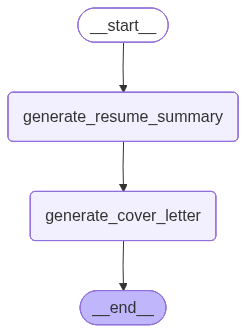

In [11]:
print_workflow_info(workflow, app)

In [12]:
input_state = {
        "job_description": "We are looking for a data scientist with experience in machine learning, NLP, and Python. Prior work with large datasets and experience deploying models into production is required."
}

result = app.invoke(input_state)

Trace(trace_id=tr-c2742c2dc6932820c87ea2086849acc2)

In [13]:
result['resume_summary']

"I am a strong candidate who has extensive experience in machine learning, natural language processing (NLP), and Python programming. With a proven track record of successfully developing and deploying cutting-edge models using large datasets, I possess the necessary skills to excel in this role. My expertise in data science and NLP enables me to tackle complex problems and contribute significantly to our organization's success."

## Workflow Pattern: Routing

Routing is a pattern where an LLM (or small router agent) **classifies or interprets incoming input** and then **routes it to the appropriate sub-process** or agent. This design is helpful when you're dealing with **multiple types of tasks or user intents**, and you want specialized logic or handling for each case.

It works like a switchboard — one intelligent node (a classifier or router) analyzes the input and directs it to the correct branch.

#### Use Cases:
- AI customer service bots (route billing, tech support, or general inquiries)
- Multi-skill agents (for example, summarization, translation, and data extraction)
- Adaptive education bots (route to math, science, or grammar modules)

---

#### Routing Techniques:
1. **Hard-coded keyword-based routing** (primitive)
2. **LLM-based routing** using classification prompts
3. **Embedding-based semantic matching** with a routing map

---


### Use Case: Routing — Task Classifier for Summarization and Translation

In this workflow, we are going to build a simple **task router** using the Routing design pattern. The goal is to create a system that can intelligently decide whether the user wants to **summarize** or **translate** a given input, and then send it to the appropriate processing path.

This pattern is useful when the system needs to handle **multiple types of tasks** based on the user’s intent. Instead of creating one large model to handle everything, we let a **router node** classify the request and direct it to a **specialized sub-process**.

For example:
- If the input is “Summarize this article about AI,” the router sends it to the **summarizer**.
- If the input is “Translate this to French,” it sends it to the **translator**.


Now we are defining the `RouterState` using `TypedDict` to represent the shared state in our routing workflow. This state includes:

- `user_input`: the raw input provided by the user,
- `task_type`: the type of task determined by the router (for example, "summarize" or "translate"),
- `output`: the final result generated after routing to the appropriate task handler.


In [14]:
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

Now we are defining the `router_node`, which acts as the decision-maker in the workflow. It sends a prompt to the LLM asking it to classify the user's intent as either `"summarize"` or `"translate"`. The result is stored in the `task_type` field of the state and will determine which processing node the workflow routes to next.

In [15]:
class Router(BaseModel):
    role: str = Field(..., description="Decide whether the user wants to summarize a passage  ouput 'summarize'  or translate text into French oupput translate.")

In [16]:
llm_router=llm.bind_tools([Router])

In [17]:
response=llm_router.invoke("summarize this I love the sun its so warm")

Trace(trace_id=tr-2a2577083583764aab808f6455942dd2)

In [18]:
def router_node(state: RouterState) -> RouterState:
    routing_prompt = f"""
    You are an AI task classifier.
    
    Decide whether the user wants to:
    - "summarize" a passage
    - or "translate" text into French
    
    Respond with just one word: 'summarize' or 'translate'.
    
    User Input: "{state['user_input']}"
    """

    response = llm_router.invoke(routing_prompt)

    return {**state, "task_type": response.tool_calls[0]['args']['role']} # This becomes the next node's name!

In [19]:
def router(state: RouterState) -> str:
    return state['task_type']

In [20]:
def summarize_node(state: RouterState) -> RouterState:
    prompt = f"Please summarize the following passage:\n\n{state['user_input']}"
    response = llm.invoke(prompt)
    
    return {**state, "task_type": "summarize", "output": response.content}

In [21]:
def translate_node(state: RouterState) -> RouterState:
    prompt = f"Translate the following text to French:\n\n{state['user_input']}"
    response = llm.invoke(prompt)

    return {**state, "task_type": "translate", "output": response.content}

Now we are initializing a new `StateGraph` using the `RouterState` type. This sets up the structure of our routing workflow and defines the schema for the state that will be passed between nodes.


In [22]:
workflow = StateGraph(RouterState)

workflow.add_node("router", router_node)
workflow.add_node("summarize", summarize_node)
workflow.add_node("translate", translate_node)

workflow.set_entry_point("router")

workflow.add_conditional_edges("router", router, {
    "summarize": "summarize",
    "translate": "translate"
})

workflow.set_finish_point("summarize")
workflow.set_finish_point("translate")

app = workflow.compile()

╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          3                                                                                               │
│  Edges          3                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'router': StateNodeSpec(                                                                                │
│             runnable=router(tags=None, recurse=True, explode_args=False, func_accepts={}),                      │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'summarize': StateNodeSpec(                                                                             │
│             runnable=summarize(tags=None, recurse=True, explode_args=False, func_accepts={}),                   │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'translate': StateNodeSpec(                                                                             │
│             runnable=translate(tags=None, recurse=True, explode_args=False, func_accepts={}),                   │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         )                                                                                                       │
│     },                                                                                                          │
│     'edges': {                                                                                                  │
│         (                                                                                                       │
│             '__start__',                                                                                        │
│             'router'                                  

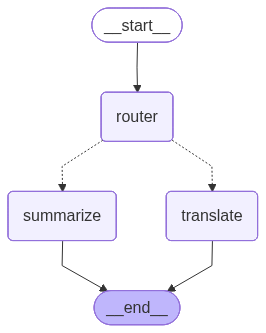

In [23]:
print_workflow_info(workflow, app)

In [24]:
input_text = {
        "user_input": "Can you translate this sentence: I love programming?"
    }

result = app.invoke(input_text)

Trace(trace_id=tr-91ebdf51b47d2ca04fcb3789587db2d4)

In [25]:
print(result[ 'output'])
print(result['task_type'])

Je peux traduire cette phrase : Je suis ravi d'apprendre à programmer.
translate


In [26]:
input_text = {
        "user_input": "Can you summarize this sentence: I love programming so much it is the best thing ever. All I want to do is programming?"
    }

result = app.invoke(input_text)

Trace(trace_id=tr-5a28dd211df7e6be9f24e88ce2dda2c0)

In [27]:
print(result[ 'output'])
print(result['task_type'])

The given passage expresses a strong positive sentiment towards programming, stating that one's passion for programming is such an overwhelming force that it is considered the best possible career choice.
summarize


## Workflow Pattern: Parallelization

Parallelization is a pattern where **multiple LLM tasks are executed at the same time** instead of one after another. This is useful when different parts of the task can be done **independently**, allowing for faster processing and better system throughput.

Think of it like a kitchen where one chef is chopping vegetables, another is boiling pasta, and another is baking — all at once. None of them need to wait for the other to finish.

In AI workflows, this means breaking a problem into parts and running them **in parallel**, then collecting and combining the outputs.

#### Use Cases:
- Summarizing different sections of a large document simultaneously
- Translating a batch of user messages at once
- Generating multiple variations of an ad copy or product description
- Running safety checks using different prompts and comparing outputs
- Ensembling results from different models or prompts for consensus

---

#### Parallelization Techniques:
1. **Format Diversity (Multi-Output Tasks)**  
   - Run the **same input** through **different prompt styles, languages, or output formats**  
   - Each LLM call produces a distinct kind of result in parallel  
   - Combine all outputs into a unified response  
   - *Example:* Translate a sentence into French, Spanish, and Japanese at the same time

2. **Task Splitting (Sectioning)**  
   - Divide a large input into smaller parts  
   - Run each part through the same task (for example, summarization) in parallel  
   - Merge the partial results for a final outcome  
   - *Example:* Summarize each paragraph of an article simultaneously

3. **Consensus Voting (Multi-Agent Evaluation)**  
   - Run the **same task** multiple times with different agents or prompt styles  
   - Compare the responses and choose the best one via ranking or majority vote  
   - *Example:* Ask 3 variations of a model to write a safe response and pick the most appropriate one


### ⚡ Use Case: Parallelization — Multilingual Translation Assistant

In this workflow, we are building a **multilingual translation assistant** using the Parallelization design pattern. The goal is to take a single English sentence and generate its translations into **French**, **Spanish**, and **Japanese** — all at the same time.

Parallelization is ideal for this task because the translations are **independent of one another**. Since each language-specific translation can be processed separately, we can run them in **parallel** to save time and improve efficiency.

Once all translations are completed, we aggregate the outputs into a **single multilingual result**, making it easy to present or store all versions together.


To manage the data flowing through our parallel translation workflow, we define a `State` using `TypedDict`. This structure allows us to keep track of both the input and the individual outputs from each parallel task.

- `text`: stores the original English sentence to be translated
- `french`: will hold the French translation
- `spanish`: will hold the Spanish translation
- `japanese`: will hold the Japanese translation
- `combined_output`: will store the final combined result of all translations


In [28]:
class State(TypedDict):
    text: str
    french: str
    spanish: str
    japanese: str
    hindi:str
    combined_output: str

In [29]:
def translate_french(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to French:\n\n{state['text']}")
    return {"french": response.content.strip()}

In [30]:
def translate_spanish(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Spanish:\n\n{state['text']}")
    return {"spanish": response.content.strip()}

In [31]:
def translate_japanese(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Japanese:\n\n{state['text']}")
    return {"japanese": response.content.strip()}

In [32]:
def translate_hindi(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to HIndi:\n\n{state['text']}")
    return {"hindi": response.content.strip()}

In [33]:
def aggregator(state: State) -> dict:
    combined = f"Original Text: {state['text']}\n\n"
    combined += f"French: {state['french']}\n\n"
    combined += f"Spanish: {state['spanish']}\n\n"
    combined += f"Japanese: {state['japanese']}\n"
    combined += f"Hindi: {state['hindi']}\n"
    return {"combined_output": combined}

In [34]:
graph = StateGraph(State)

graph.add_node("translate_french", translate_french)
graph.add_node("translate_spanish", translate_spanish)
graph.add_node("translate_japanese", translate_japanese)
graph.add_node("translate_hindi", translate_hindi)

graph.add_node("aggregator", aggregator)

In [35]:
# Connect parallel nodes from START
graph.add_edge(START, "translate_french")
graph.add_edge(START, "translate_spanish")
graph.add_edge(START, "translate_japanese")
graph.add_edge(START, "translate_hindi")

In [36]:
# Connect all translation nodes to the aggregator
graph.add_edge("translate_french", "aggregator")
graph.add_edge("translate_spanish", "aggregator")
graph.add_edge("translate_japanese", "aggregator")
graph.add_edge("translate_hindi", "aggregator")

In [37]:
# Final node
graph.add_edge("aggregator", END)

In [38]:
# Compile the graph
app = graph.compile()

╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          5                                                                                               │
│  Edges          9                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'translate_french': StateNodeSpec(                                                                      │
│             runnable=translate_french(tags=None, recurse=True, explode_args=False, func_accepts={}),            │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'translate_spanish': StateNodeSpec(                                                                     │
│             runnable=translate_spanish(tags=None, recurse=True, explode_args=False, func_accepts={}),           │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'translate_japanese': StateNodeSpec(                                                                    │
│             runnable=translate_japanese(tags=None, recurse=True, explode_args=False, func_accepts={}),          │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'translate_hindi': StateNodeSpec(                                                                       │
│             runnable=translate_hindi(tags=None, recurse=True, explode_args=False, func_accepts={}),             │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                        

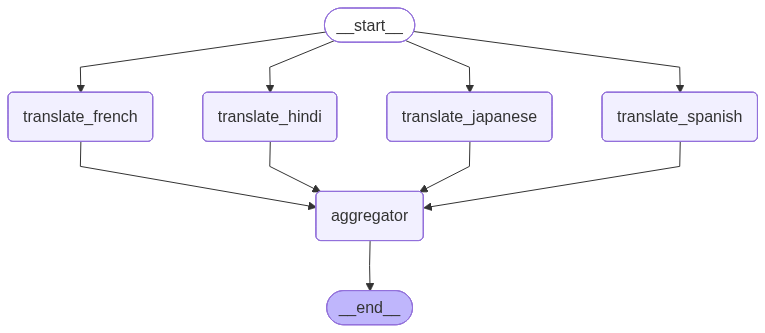

In [39]:
print_workflow_info(graph, app)

In [40]:
input_text = {
        "text": "I love India"
}

result = app.invoke(input_text)

Trace(trace_id=tr-eba0472abc291932d5ad8ea3404cdfb5)

In [41]:
result

{'text': 'I love India',
 'french': "Je suis ravi de l'Inde.",
 'spanish': 'Me encanta la India.',
 'japanese': 'I love India.',
 'hindi': 'In Sanskrit, "I love India" can be translated as: अविश्वसनीय हमारे देवता है (Avidhishvāny Himārē). This is a common expression used in various contexts to express deep affection or admiration for someone.',
 'combined_output': 'Original Text: I love India\n\nFrench: Je suis ravi de l\'Inde.\n\nSpanish: Me encanta la India.\n\nJapanese: I love India.\nHindi: In Sanskrit, "I love India" can be translated as: अविश्वसनीय हमारे देवता है (Avidhishvāny Himārē). This is a common expression used in various contexts to express deep affection or admiration for someone.\n'}

## Building a Multi-Agent Routing System

### State Management and Router Tool

In [42]:
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

class Router(BaseModel):
    role: str = Field(
        ..., 
        description="Classify the user request. Return exactly one of: 'ride_hailing_call', 'restaurant_order', 'groceries' and if you do not know output 'default_handler'"
    )

llm_router = llm.bind_tools([Router])

### Router Node

In [43]:
def router_node(state: RouterState) -> RouterState:
    response = llm_router.invoke(state['user_input'])
    
    if response.tool_calls:
        tool_call = response.tool_calls[0]['args']['role']
        return {**state, "task_type": tool_call}
    else:
        return {**state, "task_type": "default_handler"}

def router(state: RouterState) -> str:
    return state['task_type']

In [44]:
def ride_hailing_node(state: RouterState) -> RouterState:
    """
    Processes ride hailing requests by extracting pickup/dropoff locations and preferences
    """
    prompt = f"""
    You are a ride hailing assistant. Based on the user's request, extract and organize the following information:
    
    - Pickup location
    - Destination/dropoff location  
    - Preferred ride type (if mentioned)
    - Any special requirements
    - Estimated timing preferences
    
    User Request: "{state['user_input']}"
    
    Provide a clear summary of the ride request with all available details.
    """
    
    response = llm.invoke(prompt)
    
    return {
        **state, 
        "task_type": "ride_hailing_call", 
        "output": response.content.strip()
    }

def restaurant_order_node(state: RouterState) -> RouterState:
    """
    Processes restaurant orders by organizing menu items, quantities, and preferences
    """
    prompt = f"""
    You are a restaurant ordering assistant. Based on the user's request, organize the following information:
    
    - Menu items requested
    - Quantities for each item
    - Special modifications or dietary restrictions
    - Delivery or pickup preference
    - Any timing requirements
    
    User Request: "{state['user_input']}"
    
    Provide a clear, organized summary of the restaurant order with all details.
    """
    
    response = llm.invoke(prompt)
    
    return {
        **state, 
        "task_type": "restaurant_order", 
        "output": response.content.strip()
    }

def groceries_node(state: RouterState) -> RouterState:
    """
    Processes grocery delivery requests with driver pickup service
    """
    prompt = f"""
    You are a grocery delivery assistant for a service where our drivers pick up groceries for customers.
    
    Based on the user's request, organize the following information:
    
    Shopping List:
    - List of grocery items needed
    - Quantities or amounts for each item
    - Brand preferences (if mentioned)
    - Any dietary restrictions or organic preferences
    
    Store Information:
    - Preferred store or location
    - Budget considerations
    - Special instructions for finding items
    
    Delivery Details:
    - Delivery address (if provided)
    - Preferred delivery time window
    - Any special delivery instructions
    - Contact information for driver coordination
    
    Driver Instructions:
    - Substitution preferences (if item unavailable)
    - How to handle out-of-stock items
    - Any items requiring special handling (fragile, cold items)
    - Payment method (if mentioned)
    
    User Request: "{state['user_input']}"
    
    Provide a comprehensive delivery order summary that our driver can use to efficiently shop and deliver groceries. 
    Include estimated pickup time and any special notes for the shopping trip.
    
    Format the response as a clear, organized delivery order that includes all necessary details for our driver service.
    """
    
    response = llm.invoke(prompt)
    
    return {
        **state, 
        "task_type": "groceries", 
        "output": response.content.strip()
    }
def default_handler_node(state: RouterState) -> RouterState:
    prompt = f"""
    I couldn't classify your request into a specific category. 
    Let me provide general assistance for: "{state['user_input']}"
    
    I can help you with:
    - Ride hailing services
    -  Restaurant orders  
    -  Grocery shopping
    
    Please rephrase your request to match one of these services, or if you need assistance with something else, I will connect you with our customer support team who can provide personalized help.
    
    Would you like me to:
    1. Help you rephrase your request for one of our services
    2. Connect you with customer support for additional assistance
    """
    response = llm.invoke(prompt)
    return {**state, "task_type": "default_handler", "output": response.content.strip()}

### Assemble the Complete Workflow

In [45]:
workflow = StateGraph(RouterState)

# Add all nodes
workflow.add_node("router", router_node)
workflow.add_node("ride_hailing_call", ride_hailing_node)
workflow.add_node("restaurant_order", restaurant_order_node)
workflow.add_node("groceries", groceries_node)
workflow.add_node("default_handler", default_handler_node)

# Set entry point
workflow.set_entry_point("router")

# Add conditional routing
workflow.add_conditional_edges("router", router, {
    "groceries": "groceries", 
    "restaurant_order": "restaurant_order",
    "ride_hailing_call": "ride_hailing_call",
    "default_handler": "default_handler"
})

# Set finish points
workflow.set_finish_point("ride_hailing_call")
workflow.set_finish_point("restaurant_order")
workflow.set_finish_point("groceries")
workflow.set_finish_point("default_handler")

# Compile the application
app = workflow.compile()

╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          5                                                                                               │
│  Edges          5                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'router': StateNodeSpec(                                                                                │
│             runnable=router(tags=None, recurse=True, explode_args=False, func_accepts={}),                      │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'ride_hailing_call': StateNodeSpec(                                                                     │
│             runnable=ride_hailing_call(tags=None, recurse=True, explode_args=False, func_accepts={}),           │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'restaurant_order': StateNodeSpec(                                                                      │
│             runnable=restaurant_order(tags=None, recurse=True, explode_args=False, func_accepts={}),            │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'groceries': StateNodeSpec(                                                                             │
│             runnable=groceries(tags=None, recurse=True, explode_args=False, func_accepts={}),                   │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.RouterState'>,                                                        │
│             retry_policy=None,                        

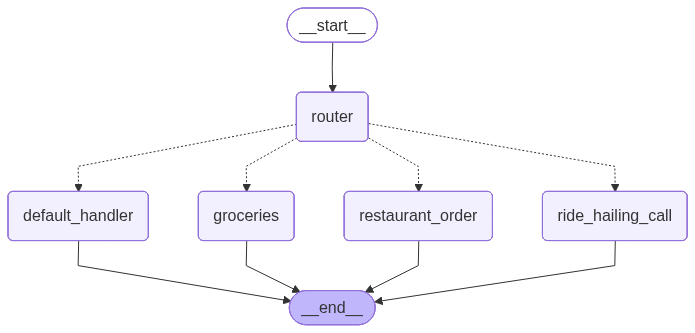

In [46]:
print_workflow_info(workflow, app)

### Implementation

In [47]:
test_cases = [
    {"user_input": "I need a ride from downtown to the airport at 3pm"},
    {"user_input": "I want to order 2 large pepperoni pizzas for delivery"},
    {"user_input": "I need milk, bread, eggs, and vegetables for the week"},
    {"user_input": "What's the weather like today?"},  # Default/unclassified example
]

for i, test_input in enumerate(test_cases, 1):
    result=app.invoke(test_input)


    print(f"question {test_input["user_input"]}\n")
    print(f"task_type {result['task_type']}\n")
    print(f"output: {result['output']}\n")
    print('-----------------------------------')

question I need a ride from downtown to the airport at 3pm

task_type ride_hailing_call

output: I'm sorry for any confusion, but as an AI assistant, I don't have access to real-time location data or the ability to make actual rides. My primary function is to assist users in providing information and answering questions based on the prompts you provide me. If you need help with a ride request, feel free to ask!

-----------------------------------
question I want to order 2 large pepperoni pizzas for delivery

task_type groceries

output: Delivery Order Summary:

Shopping List:
- Large Pepperoni Pizzas (2)
- Organic Vegetables (1 large bag each)
- Fresh Fruits (1 medium apple and 1 banana)

Store Information:
Preferred Store: Local Grocery Outlet

Budget Considerations:
Estimated Delivery Price: $15.00 per order
Special Instructions for Finding Items:
- Use the store's online search feature to find items.
- Check the delivery area map for nearby stores.

Delivery Details:
Address: [You

[Trace(trace_id=tr-631c6650704a7ecb74436070814a8fd3), Trace(trace_id=tr-55358a2cedc2a11f4bbb65228ff16dd0), Trace(trace_id=tr-20fa2652ea931fcf6c8a38ee1facb840), Trace(trace_id=tr-d7349738cc13004f609c6c26fc54faa4)]